In [1]:
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from example_reactiondiffusion import get_rd_data
from example_lorenz import generate_lorenz_data, get_lorenz_data
import os
import pickle
from autoencoder import FullNetwork as FullNetwork
import torch
from training_torch import prepare_data
from sindy_utils import sindy_simulate

data_path = os.getcwd() + '\\'
save_name = 'rd_2024_05_29_19_40_26_562696'
# save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name
# dataframe = pd.read_pickle('model1_params.pkl')
# print(dataframe)
# print(dataframe['coefficient_mask'])

def convert_to_cpu_numpy(obj):
    """
    Recursively convert torch.Tensor objects to numpy arrays,
    handling dictionaries and lists.
    
    Parameters:
    obj (any): The object to convert, which could be a tensor, list, or dictionary.

    Returns:
    any: The converted object with tensors replaced by numpy arrays.
    """
    if isinstance(obj, torch.Tensor):
        return obj.cpu().numpy()  #
    elif isinstance(obj, dict):
        #
        return {k: convert_to_cpu_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        # 
        return [convert_to_cpu_numpy(v) for v in obj]
    else:
        return obj  
# dataframe['coefficient_mask'] = dataframe['coefficient_mask'].apply(convert_to_cpu_numpy)
# dataframe['sindy_coefficients'] = dataframe['sindy_coefficients'].apply(convert_to_cpu_numpy)


# Xi_plot = np.array(dataframe['coefficient_mask']*dataframe['sindy_coefficients'])[0]
# sindy_coefficients = np.array(dataframe['sindy_coefficients'])[0]
# coefficient_mask = np.array(dataframe['coefficient_mask'])[0]
# print(dataframe['coefficient_mask'][0])
   

In [2]:
params['device'] = 'cuda:0'
autoencoder_network = FullNetwork(params).to(params['device'])
path = data_path + 'rd_2024_05_29_19_40_26_562696.pth'
state_dict = torch.load(path)
# print state_dict values
# for key in state_dict:
#     print(key)
#     print(state_dict[key])
autoencoder_network.load_state_dict(state_dict)

Xi_plot = np.array(state_dict['coefficient_mask']*state_dict['sindy_coefficients'])
print(Xi_plot)
sindy_coefficients = np.array(state_dict['sindy_coefficients'])
print(sindy_coefficients)
coefficient_mask = np.array(state_dict['coefficient_mask'])
print(coefficient_mask)

[[ 2.97893945e-04 -1.09254404e-04]
 [-2.37402768e-04  1.03357887e+00]
 [ 1.23719292e-06  1.14757830e-04]
 [ 2.05933582e-04 -1.44632504e-04]
 [ 1.67639519e-06  6.21585496e-05]
 [-8.64772301e-05 -7.52980268e-05]
 [ 3.24941539e-05  5.17045119e-05]
 [-1.94732231e-04 -3.42745188e-04]
 [ 7.68819373e-05  5.24390562e-05]
 [ 8.30761783e-05  1.63013785e-04]
 [ 1.71422667e-04 -8.54500031e-05]
 [-8.75020146e-01 -1.19821925e-06]]
[[ 2.97893945e-04 -1.09254404e-04]
 [-2.37402768e-04  1.03357887e+00]
 [ 1.23719292e-06  1.14757830e-04]
 [ 2.05933582e-04 -1.44632504e-04]
 [ 1.67639519e-06  6.21585496e-05]
 [-8.64772301e-05 -7.52980268e-05]
 [ 3.24941539e-05  5.17045119e-05]
 [-1.94732231e-04 -3.42745188e-04]
 [ 7.68819373e-05  5.24390562e-05]
 [ 8.30761783e-05  1.63013785e-04]
 [ 1.71422667e-04 -8.54500031e-05]
 [-8.75020146e-01 -1.19821925e-06]]
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


In [5]:
_,_,test_data = get_rd_data()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = autoencoder_network
model.load_state_dict(state_dict)
model.eval()  


test_dictionary = prepare_data(test_data,params,device)


test_dictionary_ = {}
for key in test_dictionary:
    if key == "x" or key =="dx":
        test_dictionary_[key] = torch.tensor(test_dictionary[key]).to(device)


with torch.no_grad():  
    torch_results = model(**test_dictionary_)

test_set_results = []
for i, output in enumerate(torch_results):
    test_set_results.append(output.cpu().detach().numpy())

# return z, x_decode, dz, dx_decode, sindy_predict,x, dx, self.sindy_coefficients

C:\Users\zhaox\AppData\Local\Temp\ipykernel_24444\2991981673.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dictionary_[key] = torch.tensor(test_dictionary[key]).to(device)


Single plot

In [7]:
z_sim = sindy_simulate(test_set_results[0][0], test_data['t'][:,0],
                       params['coefficient_mask']*test_set_results[-1],
                       params['poly_order'], params['include_sine'])

C:\Users\zhaox\AppData\Local\Temp\ipykernel_24444\4031564177.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(test_set_results[0][:,0], 'k', color='#888888', linewidth=2)


(-49.95, 1048.95, -0.9371182501316071, 0.9419650614261628)

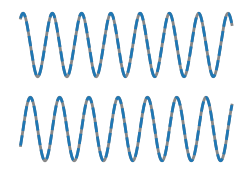

In [9]:
plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results[0][:,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(test_set_results[0][:,1], color='#888888', linewidth=2)
plt.plot(z_sim[:,1], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

([], [])

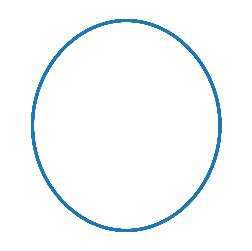

In [10]:
plt.figure(figsize=(3,3))
plt.plot(z_sim[:,0], z_sim[:,1], linewidth=2)
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

In [12]:
# return z, x_decode, dz, dx_decode, sindy_predict,x, dx, self.sindy_coefficients
decoder_x_error = np.mean((test_data['x'] - test_set_results[1])**2)/np.mean(test_data['x']**2)
decoder_dx_error = np.mean((test_data['dx'] - test_set_results[3])**2)/np.mean(test_data['dx']**2)
sindy_dz_error = np.mean((test_set_results[2] - test_set_results[4])**2)/np.mean(test_set_results[2]**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_dx_error)
print('SINDy reltive error, z: %f' % sindy_dz_error)

Decoder relative error: 0.015798
Decoder relative SINDy error: 0.015669
SINDy reltive error, z: 0.001844
